In [3]:
import pandas as pd
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Extracting data from the dataset's zip file
zip_path = '/content/icc_mens_cricket_world_cup_csv.zip'
extract_path = '/content/icc_matches'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Parsing only match info (not ball-by-ball) from each file
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]

def parse_match_info(file_path):
    match_info = {'file': file_path}
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('info'):
                parts = line.strip().split(',', maxsplit=2)
                if len(parts) == 3:
                    _, key, value = parts
                    if key in ['date', 'venue', 'toss_winner', 'toss_decision', 'player_of_match', 'winner', 'team', 'match_number']:
                        if key == 'team':
                            match_info.setdefault('teams', []).append(value)
                        else:
                            match_info[key] = value
    if 'teams' in match_info and len(match_info['teams']) == 2:
        match_info['team1'] = match_info['teams'][0]
        match_info['team2'] = match_info['teams'][1]
    return match_info if 'winner' in match_info else None

all_matches = []
for file in csv_files:
    info = parse_match_info(os.path.join(extract_path, file))
    if info:
        all_matches.append(info)

matches_df = pd.DataFrame(all_matches)
print("Loaded matches:", len(matches_df))

# Preprocessing
matches_df['date'] = pd.to_datetime(matches_df['date'], errors='coerce')
matches_df.dropna(subset=['date', 'venue', 'toss_winner', 'toss_decision', 'team1', 'team2', 'winner'], inplace=True)

# Encoding categorical features

le_venue = LabelEncoder()
le_toss = LabelEncoder()
le_decision = LabelEncoder()
le_winner = LabelEncoder()

# Combining all team names before fitting
all_teams = pd.concat([matches_df['team1'], matches_df['team2']]).unique()
le_team = LabelEncoder()
le_team.fit(all_teams)

# Now transforming
matches_df['team1_enc'] = le_team.transform(matches_df['team1'])
matches_df['team2_enc'] = le_team.transform(matches_df['team2'])

matches_df['toss_winner_enc'] = le_toss.fit_transform(matches_df['toss_winner'])
matches_df['venue_enc'] = le_venue.fit_transform(matches_df['venue'])
matches_df['toss_decision_enc'] = le_decision.fit_transform(matches_df['toss_decision'])
matches_df['winner_enc'] = le_winner.fit_transform(matches_df['winner'])

# Feature matrix and target
X = matches_df[['team1_enc', 'team2_enc', 'toss_winner_enc', 'toss_decision_enc', 'venue_enc']]
y = matches_df['winner_enc']

# Split & Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
labels_in_test = sorted(y_test.unique())
target_names_in_test = le_winner.inverse_transform(labels_in_test)
print(classification_report(y_test, y_pred, labels=labels_in_test, target_names=target_names_in_test))



Loaded matches: 257
Accuracy: 0.4807692307692308
              precision    recall  f1-score   support

   Australia       1.00      0.89      0.94         9
  Bangladesh       0.33      0.50      0.40         2
     England       0.38      0.75      0.50         4
       India       0.71      0.62      0.67         8
     Ireland       0.00      0.00      0.00         1
       Kenya       0.00      0.00      0.00         1
 Netherlands       0.00      0.00      0.00         1
 New Zealand       0.80      0.57      0.67         7
    Pakistan       0.29      0.50      0.36         4
South Africa       0.00      0.00      0.00         6
   Sri Lanka       0.29      0.40      0.33         5
 West Indies       0.00      0.00      0.00         3
    Zimbabwe       0.00      0.00      0.00         1

    accuracy                           0.48        52
   macro avg       0.29      0.33      0.30        52
weighted avg       0.48      0.48      0.47        52



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


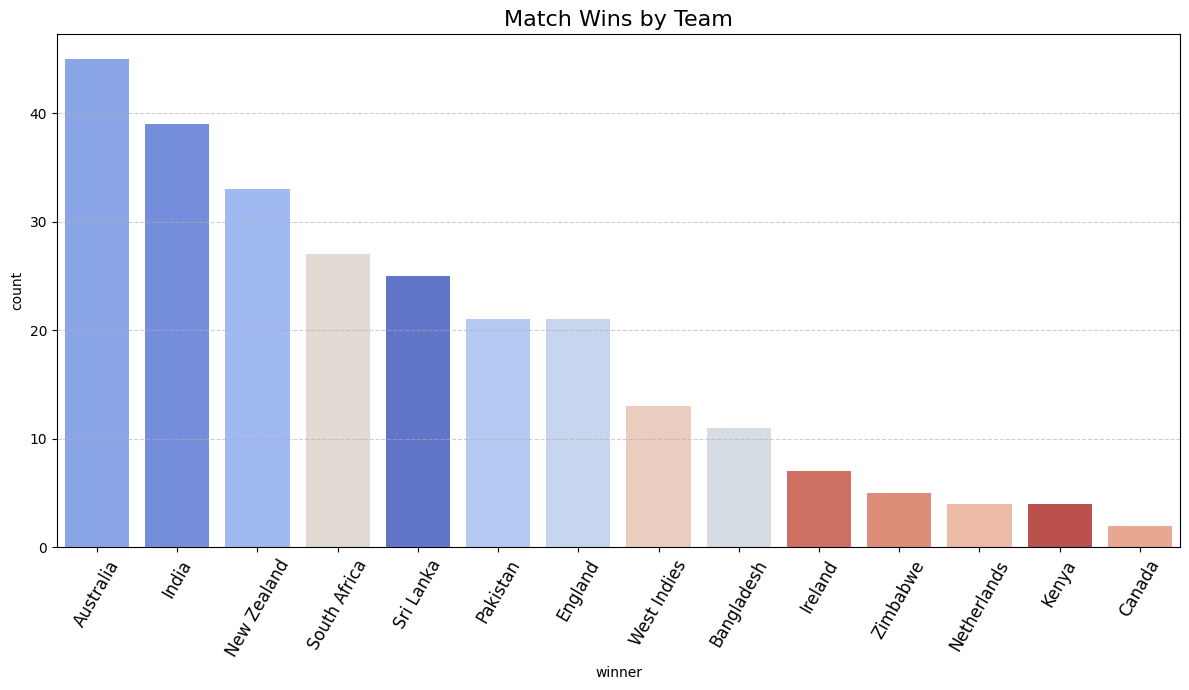

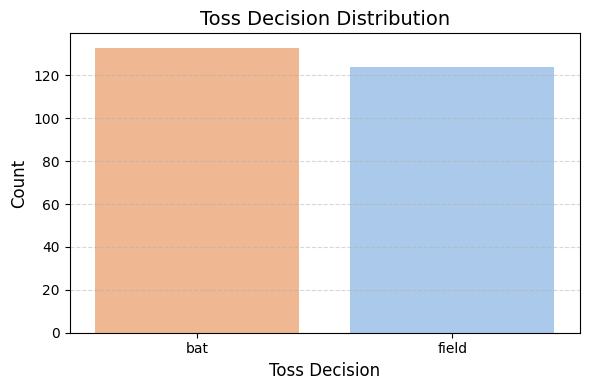

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: Match Wins by Team
order = matches_df['winner'].value_counts().index

plt.figure(figsize=(12, 7))
sns.countplot(
    data=matches_df,
    x='winner',
    hue='winner',
    order=order,
    palette='coolwarm',
    legend=False
)
plt.xticks(rotation=60, fontsize=12)
plt.title('Match Wins by Team', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Plot 2: Toss Decision Distribution
toss_order = ['bat', 'field']

plt.figure(figsize=(6, 4))
sns.countplot(
    data=matches_df,
    x='toss_decision',
    hue='toss_decision',
    order=toss_order,
    palette='pastel',
    legend=False
)
plt.title('Toss Decision Distribution', fontsize=14)
plt.xlabel('Toss Decision', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
